# Preprocessing and clustering of the 3k PBMCs dataset
v2023-11-15

We gratefully acknowledge Seurat’s and Scanpy's authors for the tutorials.

We used the same data (3k PBMCs) from a Healthy Donor, which are freely available from 10x Genomics ([download page](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). 

In [1]:
""" 
Reset the tutorial
"""
# delete the intermediate output folders to reset the tutorials
!rm -rf "data/"
!rm -rf "output/"

In [2]:
"""
Download the data and create output folders
"""
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data && tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz && gzip filtered_gene_bc_matrices/hg19/* && mv filtered_gene_bc_matrices/hg19/genes.tsv.gz filtered_gene_bc_matrices/hg19/features.tsv.gz
!mkdir output

--2023-11-18 17:38:32--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2023-11-18 17:38:33--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  3.82MB/s    in 1.9s    

2023-11-18 17:38:35 (3.82 MB/s) - ‘data/pbmc3k_filtered_gene_bc_matric

In [3]:
"""
Import necessary packages
"""
# not use GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# import scelephant
import scelephant as el
from scelephant import RamData
import scanpy as sc
# set figure parameters
sc.set_figure_params( dpi = 200, figsize = ( 6, 5 ), frameon = True )

# plotly export settings
import plotly.io as pio
pio.renderers.default = "notebook"

"""
configure the jupyter notebook environment
"""
el.bk.Wide( 100 ) # adjust the jupyter notebook cell width 

import matplotlib as mpl
mpl.rcParams[ "figure.dpi" ] = 100
# set image resolution

# load memory profiler 
# %load_ext memory_profiler

## **Convert MTX -> RamData**

In [4]:
# initialize a pool of managed operators
fop = el.managers.FileSystemOperatorPool( 8 ) # this pool of managed operators will be used throughout the tutorials

# create RamData from 10X-formateed MTX
el.create_ramdata_from_mtx( 
    path_folder_mtx_10x_input = f'data/filtered_gene_bc_matrices/hg19/', 
    path_folder_ramdata_output = f'output/pbmc3k.ram/',
    file_system_operator_pool = fop,
)

## **loading RamData**

In [5]:
ram = RamData( 
    f'output/pbmc3k.ram/', 
    int_total_weight_for_each_batch = 100_000,
    int_num_cpus = 8,
    file_system_operator_pool = fop
)

2023-11-18 17:38:53,905 [SC-Elephant] <INFO> (layer) - 'raw' layer has been loaded


## **view RamData**
- JavaScript-based interactive visualization of RamData object in Jupyter Notebook

In [6]:
ram

<RamData object (2700 barcodes X 32738 features, 2286884 records in the currently active layer 'raw') stored at /home/merit_an/git/scelephant/doc/jn/tutorials/output/pbmc3k.ram/
	with the following layers : {'raw'}
		current layer is 'raw'>

## **Preprocessing of Raw count data**

In [15]:
"""
Perform preprocessing of the raw count matrix
"""
# settings
name_col_filter_filtered_barcode = 'filtered_barcodes'
flag_use_fast_mode = False # does not generate intermediate output layers for fast analysis # you can set the flag to False to generate all intermediate layers

''' preprocess outputs '''
ram.prepare_dimension_reduction_from_raw( 
    name_layer_raw = 'raw', # name of the input layer
    name_layer_capped = 'normalized_log1p_capped', # name of the output layer for dimension reduction
    name_layer_scaled = None, # does not perform scaling (capping is often sufficient)
    name_col_filter_filtered_barcode = name_col_filter_filtered_barcode, # the name of the 'barcode' axis filter that will contain filtered cells
    min_counts = 500, # cell filtering criteria
    min_features = 200, 
    max_counts = 15000,
    max_features = 2500,
    int_total_count_target = 10_000, # target count for count normalization
    int_num_highly_variable_features = 2_000, # the number of the highly-variable features for performing dimension reduction
    name_col_filter_highly_variable = 'filter_normalized_log1p_highly_variable_2000', # the name of the 'feature' axis filter that will contain detected highly variable features
    max_value = 10, 
    dict_kw_hv = { 'float_min_mean' : 0.01, 'float_min_variance' : 0.01 }, 
    flag_use_fast_mode = flag_use_fast_mode,
)

## **perform dimension reduction and clustering**

2023-11-18 17:39:57,957 [SC-Elephant] <WARNING> (train_pca) - iPCA model 'ipca' does not exist in the RamData models database, initializing the model.
30 PCs from 1999 features: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2695/2695 [00:18<00:00, 149.37it/s]
2023-11-18 17:40:17,232 [SC-Elephant] <INFO> (train_pca) - fit completed
2023-11-18 17:40:17,258 [SC-Elephant] <INFO> (load_str) - completed loading of 1999 number of strings
2023-11-18 17:40:17,285 [SC-Elephant] <INFO> (load_str) - completed loading of 1999 number of strings
2023-11-18 17:40:17,674 [SC-Elephant] <INFO> (save_model) - ipca|ipca model saved.
30 PCs from 1999 features: 100%|███████████████████████████████

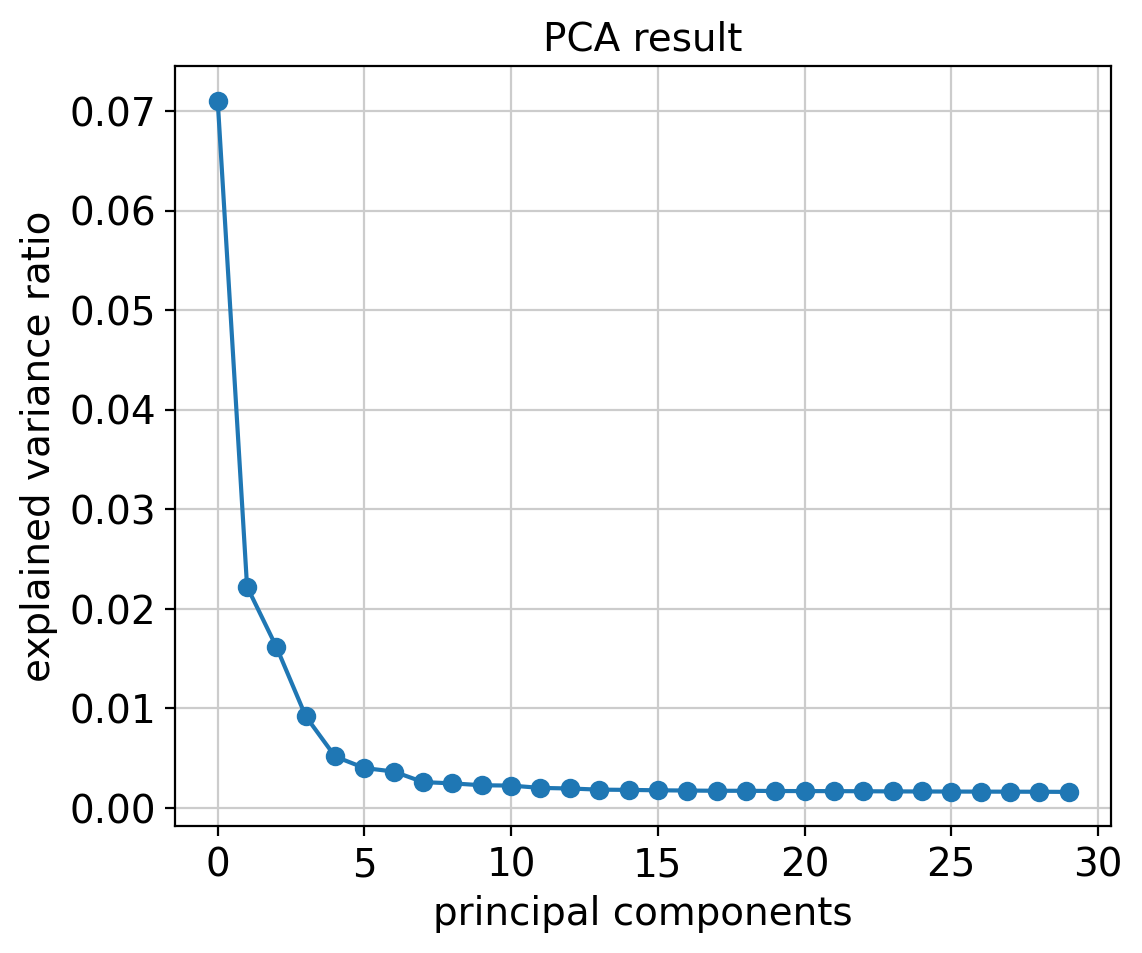

In [8]:
# perform UMAP embedding
ram.perform_dimension_reduction_and_clustering(
    name_layer_pca = 'normalized_log1p_capped', 
    name_filter_barcodes = name_col_filter_filtered_barcode,
    name_filter_features = 'filter_normalized_log1p_highly_variable_2000',
    str_embedding_method = 'scanpy-umap', # use scanpy functions to generate umap and leiden clustering results
    float_prop_subsampling_pca = 1, # use all cells without subsampling (TIP: for large dataset, it is recommended to use number below 0.5 to reduce PCA fitting time)
    dict_kw_for_run_scanpy_using_pca = {
        'int_neighbors_n_neighbors': 30, 
        'int_neighbors_n_pcs': 30, 
        'set_method': {'umap', 'leiden'}, # run umap and leiden 
        'dict_kw_leiden': {'resolution': 0.75}, 
    },
)

## **perform dimension reduction and clustering**

In [ ]:
# dict_marker_genes = {
#     'Proliferating' : [ 'MKI67' ],
#     'T-cell' : [ 'CD3D' ],
#     'CD4 T-cell' : [ 'CD4' ],
#     'CD8 T-cell' : [ 'CD8A', 'CD8B' ],
#     'Naive T / TCM' : [ 'CCR7', 'SELL' ],
#     'Effector Phenotype' : [ 'FAS', 'CD44', 'IL2RG', 'IL7R', 'CD69' ],
#     'TREG' : [ 'FOXP3', 'IL2RA' ], # , 'TNFRSF4'
#     'MAIT' : [ 'KLRB1', 'SLC4A10' ], # 'TRAJ33', 'TRAJ12', 'TRAJ20',  'CXCR6', 'TRAV1-2'
#     'SOX4+ CD4 T' : [ 'SOX4' ], # 'ID2'
#     'NK' : [ 'GNLY', 'GZMB' ],
#     'NK Recruiting (CD56 bright)' : [ 'XCL1', 'GZMK' ], 
#     'B cell' : [ 'MS4A1', 'CD79A' ], # 'CD19',  
#     'B memory' : [ 'CD27' ],
#     'Plasma cell' : [ 'TXNDC5' ],
#     'Monocyte' : [ 'CD86' ],
#     'Classical Monocyte' : [ 'CD14' ], # 'LYZ'
#     'Non-classical Monocyte' : [ 'FCGR3A' ],
#     'Macrophage' : [ 'CD68' ],
#     'Macrophage (M1)' : [ 'CD86', 'FCGR2A', ], #  'CD80'
#     'Macrophage (M2)' : [ 'CD163', 'MSR1' ], # 'MRC1'
#     'Dendritic' : [ 'FCER1A' ],
#     "cDC1" : [ 'THBD', 'CLEC9A' ], # 'XCR1'
#     'cDC2' : [ 'CD1C', 'SIRPA' ], # 'ITGAM'
#     'pDC' : [ 'CLEC4C', 'IL3RA', 'LILRA4' ], # 'NRP1'
#     'Platelet' : [ 'ITGA2B' ],
#     'HPSC' : [ 'CD34' ],
# }

2023-11-18 17:40:39,971 [SC-Elephant] <INFO> (load_str) - completed loading of 2695 number of strings
2023-11-18 17:40:40,047 [SC-Elephant] <INFO> (load_str) - completed loading of 32738 number of strings


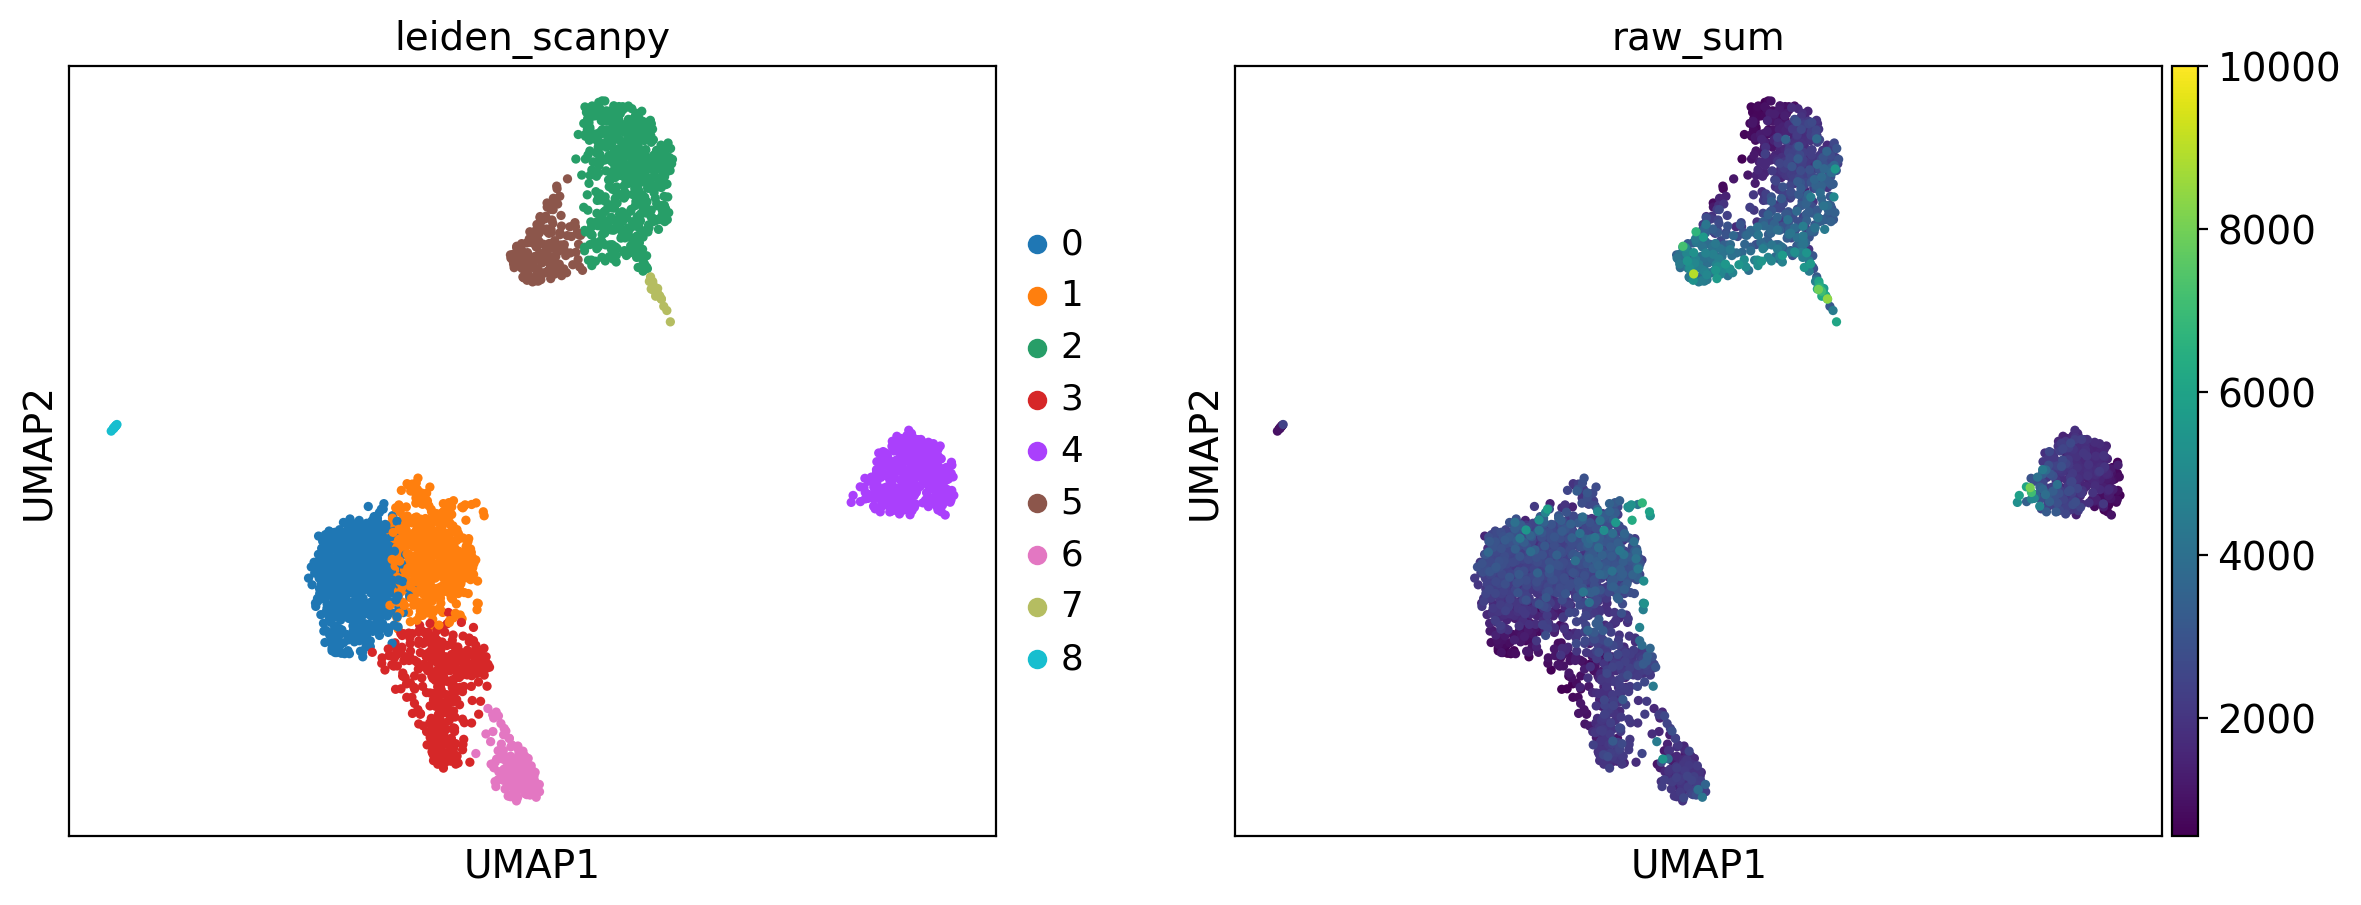

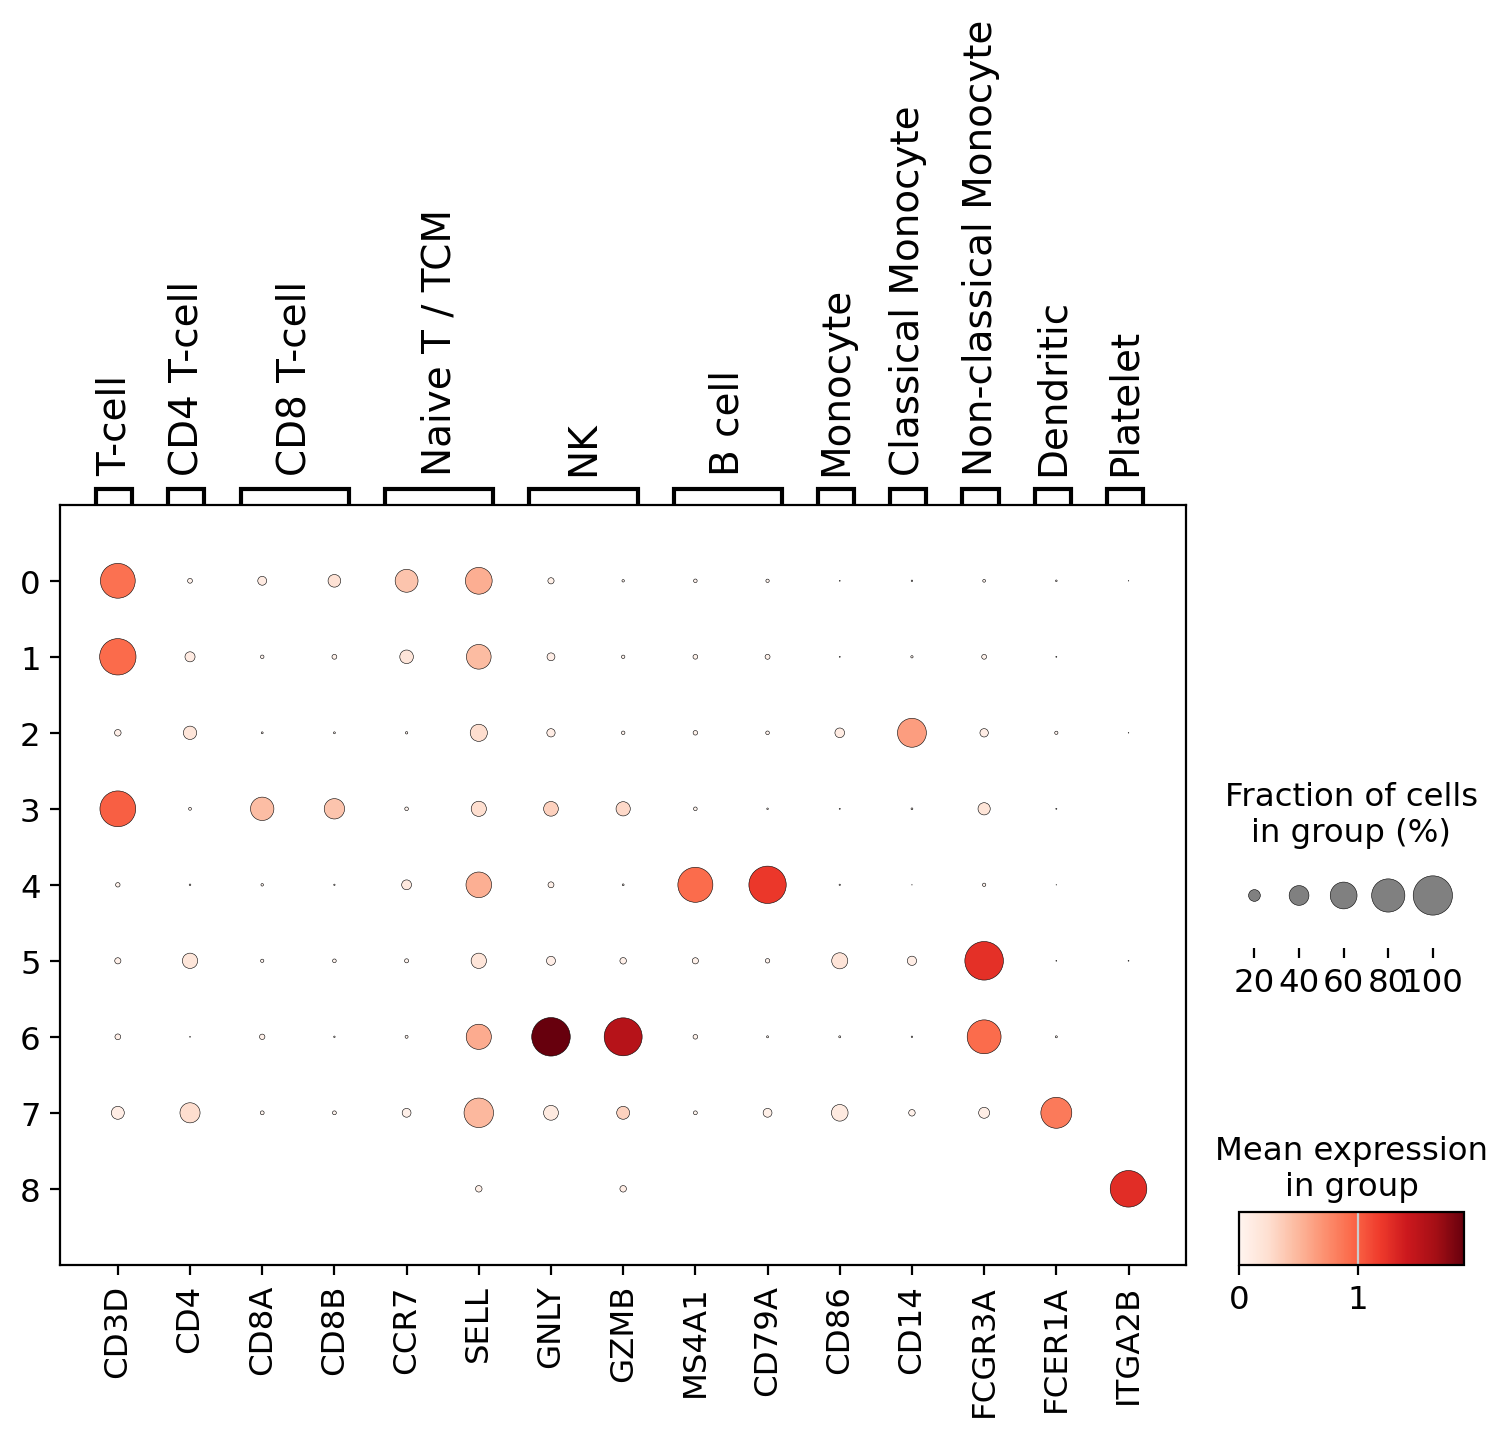

In [9]:
"""
Display UMAP clustering results with marker genes
"""
# settings
name_col_label = 'leiden_scanpy'
name_col_umap = 'X_umap_scanpy'
dict_marker_genes = {
    'T-cell' : [ 'CD3D' ],
    'CD4 T-cell' : [ 'CD4' ],
    'CD8 T-cell' : [ 'CD8A', 'CD8B' ],
    'Naive T / TCM' : [ 'CCR7', 'SELL' ],
    'NK' : [ 'GNLY', 'GZMB' ],
    'B cell' : [ 'MS4A1', 'CD79A' ], 
    'Monocyte' : [ 'CD86' ],
    'Classical Monocyte' : [ 'CD14' ], 
    'Non-classical Monocyte' : [ 'FCGR3A' ],
    'Dendritic' : [ 'FCER1A' ],
    'Platelet' : [ 'ITGA2B' ],
} # previously known cell type markers

def Get_AnnData_from_RamData( l_name_gene : list, l_name_obs : list = [ ] ) :
    ''' # 2023-11-18 16:57:29 
    Load data from RamData in the AnnData format.
    '''
    # retrieve data in SCANPY's AnnData format
    ram.ft.filter = None # reset the filter
    adata = ram[
        'normalized_log1p_capped', # [layer selection] name of the layer
        :, # [barcode selection] all active cells (barcodes) in the filter
        [ # [barcode metadata selection] e.g., annotations, barcode names, and PCA/UMAP coordinates
            'str', # 'str' meaning string representations of the cells (barcodes)
            'raw_sum', # 'n_Counts' (total number of UMIs)
            name_col_label, # clustering results
            { 'X_pca', name_col_umap } # 2D data (values stored commonly in '.obsm') should be given as a set (or dictionary, in order to specify the number of dimensions to retrieve. by default, retrieve all dimensions)
        ] + l_name_obs, 
        l_name_gene, # [feature selection] specific features
        [ 'str' ] # [feature metadata] name of the features
    ]
    adata.obsm[ 'X_umap' ] = adata.obsm[ name_col_umap ] # copy UMAP coordinates for plotting
    return adata

# retrieve AnnData containing normalized gene expression counts of a given list of marker genes
l_marker_genes = [ ] # collect the marker genes
for e in dict_marker_genes :
    l_marker_genes += dict_marker_genes[ e ]
adata = Get_AnnData_from_RamData( l_marker_genes )

# plot leiden clustering result
sc.pl.umap( adata, color = ['leiden_scanpy', 'raw_sum'], vmax = 10000 )

# show dotplot
sc.pl.dotplot( adata, dict_marker_genes, groupby = name_col_label, figsize = ( 9, 5 ) )

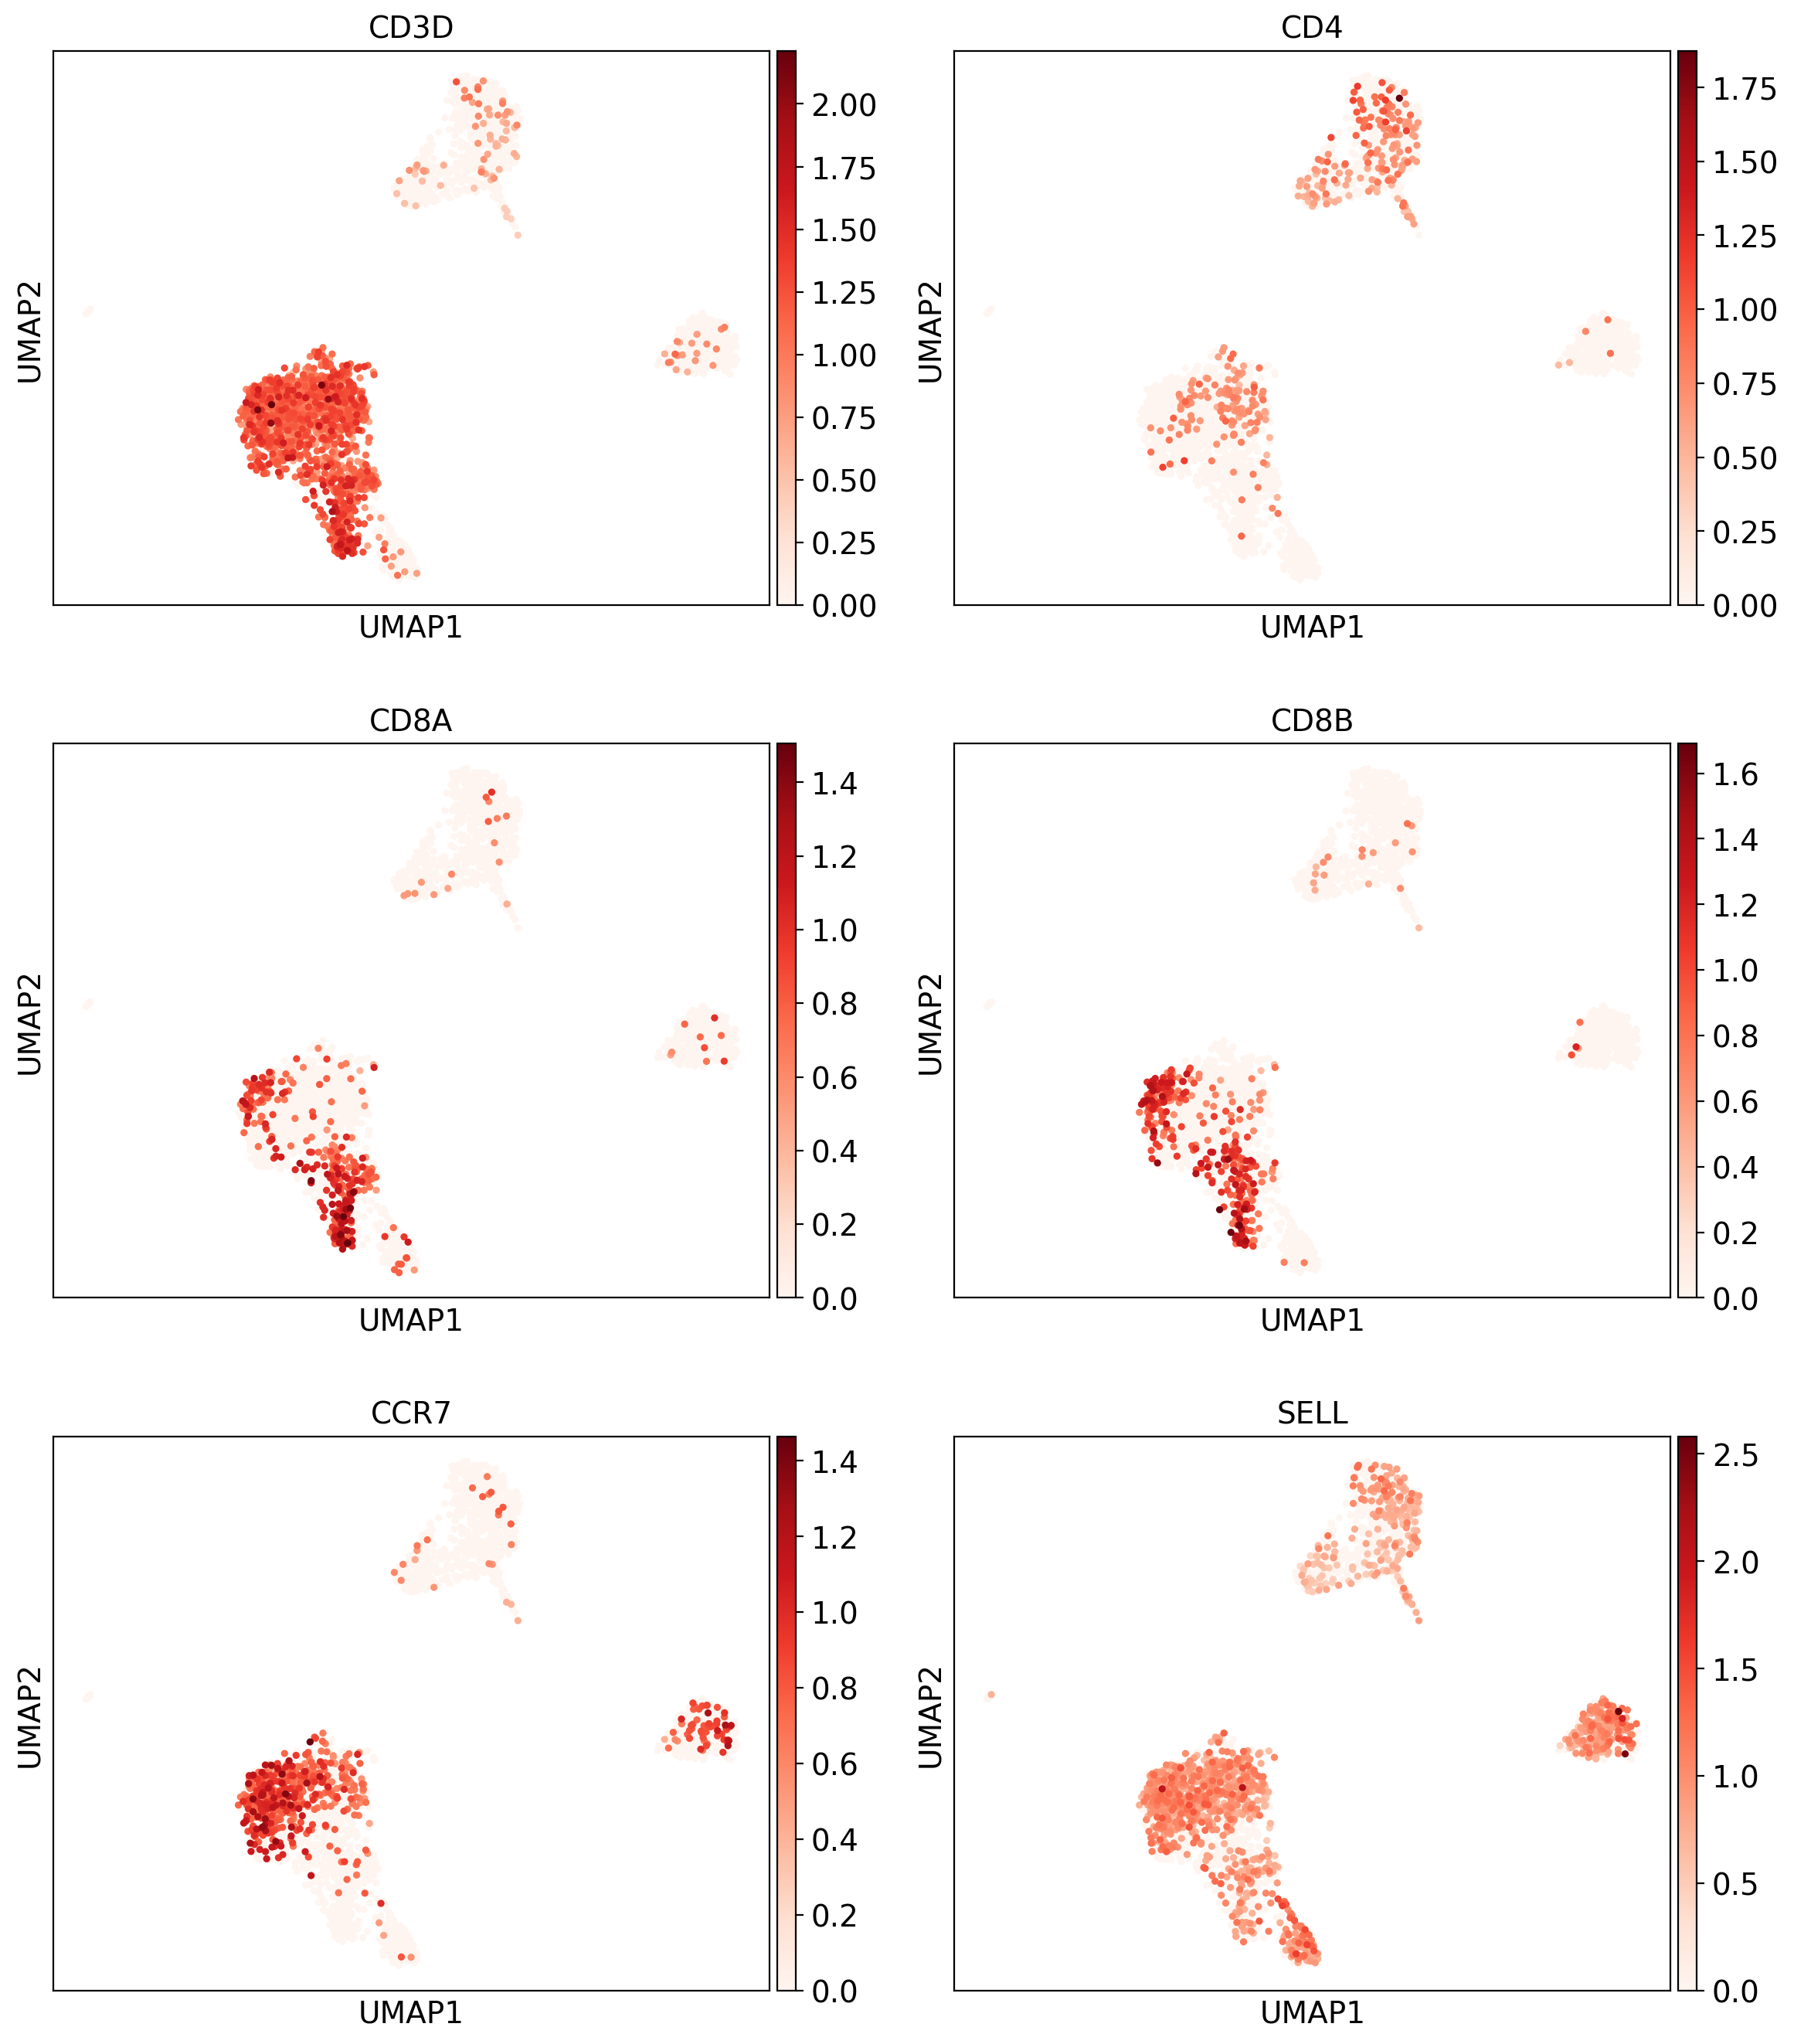

In [10]:
'''plot gene expression values'''
sc.pl.umap( adata, color = l_marker_genes[ : 6 ], cmap = 'Reds', ncols = 2 )

## **Search marker genes and annotate clusters**

SC-Elephant enables  memory-efficient marker gene search by loading expression values of each gene separately and perform several tests.
Currently, SC-Elephant supports following tests:
- Log2 Fold Change difference (cell type vs. rest)
- AUROC (area under receiver operating characteristic curve) - measures how the current gene can classify the current cell type from the rest of the cells in the dataset
- T-test (or Wilcoxon rank sum test )

In [11]:
"""
Find marker genes of each cluster
"""
# settings
flag_perform_subsampling = False # it is highly recommended to turn on cluster-based subsampling for an extremely large dataset!
name_layer = 'normalized_log1p_capped'

if flag_perform_subsampling :
    ''' subsample for each cluster using the label '''
    ram.subsample_for_each_clus( 
        name_col_label = name_col_label, 
        int_num_entries_to_subsample = int( len( ram.bc ) / 3 ),  # subsample 1/3 of cells
        index_col_of_name_col_label = -1,
        name_col_filter = name_col_filter_filtered_barcode, # input column name containing the filter to subsample
        name_col_filter_subsampled = None, # output column name to store the filter. If None is given, output to current filter object
    )

''' search marker feature for each cluster '''
ram.find_markers( 
    name_layer = name_layer, # normalized using log1p-normalized values
    name_col_label = name_col_label, # name of the annotation column to perform marker gene search
    index_name_col_label = -1, # for a typical annotation column containing 1D data array, set this value to -1 (indicating 1D)
    l_name_cluster = None, # search marker genes for all cluster labels
    name_col_log2fc = f'{name_col_label}__marker_log2fc', 
    name_col_auroc = f'{name_col_label}__marker_auroc', 
    name_col_pval = f'{name_col_label}__marker_pval', 
    method_pval = 'wilcoxon', # use wilcoxon test 
)

''' retrieve filtered marker calculation results '''
df_res = ram.get_marker_table( 
    max_pval = 1e-3, 
    min_auroc = 0.6, 
    min_log2fc = 1, 
    name_col_log2fc = f'{name_layer}_{name_col_label}__marker_log2fc', 
    name_col_auroc = f'{name_layer}_{name_col_label}__marker_auroc', 
    name_col_pval = f'{name_layer}_{name_col_label}__marker_pval', 
)
df_res # display marker gene search results

2023-11-18 17:40:44,038 [SC-Elephant] <INFO> (find_markers) - [RamData.find_markers] finding markers for 9 number of clusters started
normalized_log1p_capped / features: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2286884.0/2286884 [01:04<00:00, 35302.48it/s]
2023-11-18 17:41:49,355 [SC-Elephant] <INFO> (summarize) - summarize operation of normalized_log1p_capped in the 'feature' axis was completed
2023-11-18 17:41:49,356 [SC-Elephant] <INFO> (find_markers) - finding markers for 9 number of clusters completed


,name_feature,name_cluster,value_auroc,value_log2fc,value_pval
0,HES4,5,0.784821,5.012916,1.198525e-34
1,ISG15,2,0.693412,1.053537,9.208979e-42
2,ISG15,5,0.752974,1.144557,1.096021e-27
3,SDF4,6,0.608837,1.689237,4.881225e-06
4,RBP7,2,0.649043,4.956746,1.750609e-25
...,...,...,...,...,...
876,CSTB,5,0.774832,1.447370,2.236602e-32
877,CSTB,7,0.734083,1.110420,1.523886e-04
878,SUMO3,7,0.718719,1.445970,4.022935e-04
879,ITGB2,6,0.803003,1.276745,4.437262e-37


In [12]:
''' select the best marker genes for each cluster '''
import pandas as pd
# settings 
int_num_marker_genes_to_retrieve_for_each_cluster = 5 # show 5 best marker genes for each cluster
df_res_best = pd.concat( list( _df.sort_values( 'value_auroc', ascending = False ).iloc[ : int_num_marker_genes_to_retrieve_for_each_cluster ] for name_clus, _df in df_res.groupby( 'name_cluster' ) ) )
df_res_best # display results

,name_feature,name_cluster,value_auroc,value_log2fc,value_pval
523,CD3D,0,0.718488,1.030397,8.593731e-61
685,CCR7,0,0.697147,2.349322,7.846861e-50
817,NOSIP,0,0.682633,1.055273,5.145078e-43
711,CD7,0,0.652515,1.010316,1.627199e-30
846,PIK3IP1,0,0.646340,1.428182,3.163886e-28
629,IL32,1,0.782837,1.167961,5.834442e-90
199,IL7R,1,0.760255,1.476689,1.849589e-76
524,CD3D,1,0.734960,1.065029,1.160025e-62
522,CD3E,1,0.711379,1.045499,4.636382e-51
36,CD2,1,0.698410,1.421356,3.374307e-45


In [ ]:
''' display current categories '''
ram.bc.meta.get_categories( name_col_label )

In [18]:
''' annotate each cluster (rename categories) '''
ram.bc.meta.rename_categories( {
    '0' : 'CD4+ T cells', # can be classified as 'Naive T / TCM', but to reproduce the SCANPY tutorial's annotations, 'CD4+ T cells' will be used.
    '1' : 'CD4+ T cells',
    '2' : 'Classical Monocyte',
    '3' : 'CD8+ T-cells',
    '4' : 'B cells',
    '5' : 'Non-classical Monocyte',
    '6' : 'NK',
    '7' : 'Dendritic cells',
    '8' : 'Platelets (Possibly Megakaryocytes)', # based on the relatively low number of UMIs in this cluster, the cluster was named 'Platelets'
} )

['7', '1', '0', '4', '3', '5', '2', '8', '6']